## Simulation of  modified Stuart-Landau (MSL) model with (generalized) phase model

### Setup

In [1]:
using GeneralizedPhaseReduction
using DifferentialEquations, PyPlot
using PyCall
using ProgressMeter
axes_grid1 = pyimport("mpl_toolkits.axes_grid1")

PyObject <module 'mpl_toolkits.axes_grid1' from 'C:\\ProgramData\\Miniconda3\\lib\\site-packages\\mpl_toolkits\\axes_grid1\\__init__.py'>

In [2]:
using LinearAlgebra

### Model definition

In [58]:
dxdt(X, I, λ=5.0) = λ*(X[1]-I) - exp(I)*X[2]-λ*((X[1]-I)^2+X[2]^2)*(X[1]-I)
dydt(X, I, λ=5.0) = exp(I)*(X[1]-I) + λ*X[2]-λ*((X[1]-I)^2+X[2]^2)*X[2]
F(X, I) = [dxdt(X, I), dydt(X, I)]

D, N = 2, 5 # number of dimensions, units
Nθ = 1000
W = rand(N, N)
W -= Diagonal(W)
W ./= sum(W.^ 2, dims=2) # normalize
G(X, K) = K * (W * X[:, 1])
#G(X, K) = K * ((1 .- eye(N)) * X[:, 1])
dt = 1e-3; T = 5.0; Nt = round(Int, T/dt)
trange = range(0, T, length=Nt)
alg = Tsit5(); #Rosenbrock23() #Tsit5();

In [4]:
@time Ts, ω, Xs = find_stable_periodic_solution(F, 0, D, Nθ, [1, 0], dt, Tsit5(), 2, 0.0, print_progress=false)
println("Ts=", Ts, " (sec) , ω=", ω, " (Hz)")

  7.952079 seconds (26.75 M allocations: 1.950 GiB, 5.11% gc time, 96.79% compilation time)
Ts=6.284 (sec) , ω=0.9998703544206853 (Hz)


In [5]:
# F, Imin, Imax, dI, D, Nθ, nothing, dt, alg, origin_val_idx, origin_thr
ωI, ζθI, ξθI, XsI = generalized_phase_sensitivity_func(F, -2., 2., 0.1, D, Nθ, nothing, dt, Tsit5(), 2, 0.0);

[1/3] Computing Xs(θ, I) and Z(θ, I)... 100%|████████████| Time: 0:00:12mmm


[2/3] Computing ζ(θ, I)...
[3/3] Computing ξ(θ, I)...


In [6]:
function coupled_func!(dX, X, p, t)
    g, κ = p
    Iext = g(X) # input
    for i in 1:size(dX)[1]
        dX[i, :] = κ[i] * F(X[i, :], Iext[i])
    end
end

coupled_func! (generic function with 1 method)

### Run simulation

In [59]:
K = 0.2
κ = ones(N) #[1.0, 1.5]
initθ = rand(N)*2pi #[π/2, π]
NΘ = 100
input_mode = "I"; # "I" or "PQ"

In [60]:
g(X) = G(X, K)

g (generic function with 1 method)

In [61]:
Tos, Xos, Θgos, Θcos = coupled_original_system(N, D, T, XsI, g, coupled_func!, initθ, κ, alg);

In [62]:
size(Xos)

(1134, 5, 2)

In [63]:
maximum(Xos)

1.1597008385838625

In [64]:
minimum(Xos)

-1.3209461836551173

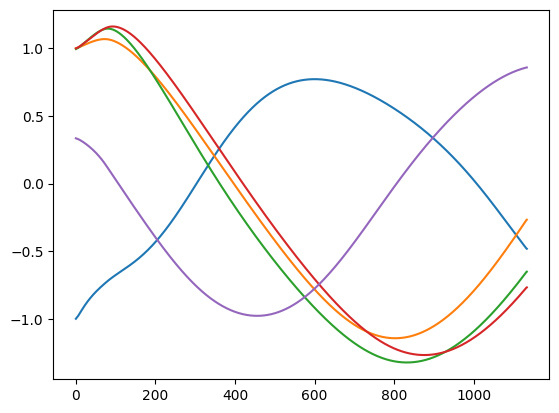

In [65]:
for i in 1:N
    plot(Xos[:, i, 1])
end

In [14]:
function compute_online_IsΘ(G, N, D, XsI, Θ, ttmax::Int=50, ϵ=1e-5)
    """
    Compute online I₀(θ)

    Args:
    - N :number of units
    - D : Dimension of states; (Int)

    Returns:
    - I₀(θ)   :  ∈ R^N
    """

    X = zeros(N, D)
    # initial I
    Iₜ = zeros(N)

    for tt in 1:ttmax
        for i in 1:N
            X[i, :] = [XsI[j](Θ[i], Iₜ[i]) for j in 1:D]
        end

        Iₜ₋₁ = copy(Iₜ)
        Iₜ = G(X) # update

        if sum(abs.(Iₜ .- Iₜ₋₁)) <  ϵ # check convergence
            break
        end
    end
    return Iₜ # save
end

compute_online_IsΘ (generic function with 3 methods)

In [15]:
compute_online_IsΘ(g, N, D, XsI, initθ)

3-element Vector{Float64}:
 0.628574672730879
 0.5682504452376754
 0.3986632166373312

In [16]:
ist(θ) = compute_online_IsΘ(g, N, D, XsI, θ)

ist (generic function with 1 method)

In [25]:
function jacobian(func, x, ϵ)
    N = size(x)[1]
    jac = zeros(N, N)
    for i in 1:N
        x1 = copy(x)
        x2 = copy(x)
        x1[i] += ϵ
        x2[i] -= ϵ
        jac[:, i] = (func(mod.(x1, 2π)) - func(mod.(x2, 2π)))/(2*ϵ)
        #jac[:, i] = (func(x1) - func(x2))/(2*ϵ)
    end
    return jac
end

jacobian (generic function with 1 method)

In [71]:
jacobian(ist, initθ, 1e-8)

5×5 Matrix{Float64}:
 -0.00190283  -0.00519084  -0.0170924   0.00761673  -0.0390744
 -0.00509117  -0.00224627  -0.0085815   0.00796822  -0.092884
 -0.00489942  -0.0123024   -0.00477668  0.00894934  -0.0582905
 -0.0110456   -0.0102965   -0.0225152   0.00406181  -0.092822
 -0.00570601  -0.00581109  -0.00504986  0.00762579  -0.0191092

In [54]:
ist(θ) = compute_online_IsΘ(g, N, D, XsI, θ)

function online_generalized_coupled_updateΘ_I(Θ, p, t)
    N, κ, ist, ωI, ξθI = p
    Θ = mod.(Θ, 2π) # θ ∈[0, 2π]
    IΘₜ = ist(Θ)
    #println("I", IΘₜ, "Θ", Θ)
    ωΘ = [κ[i] * ωI(IΘₜ[i]) for i in 1:N]
    J = jacobian(ist, Θ, 1e-6)
    XiΘ = LinearAlgebra.I　- hcat([ξθI(Θ[i], IΘₜ[i]) * J[i, :] for i in 1:N]...)'
    dΘ = XiΘ \ ωΘ # generalized phase equation
    return dΘ
end

online_generalized_coupled_updateΘ_I (generic function with 1 method)

In [50]:
# for adaptive time step
function online_coupled_generalized_phase_model_I(N::Int, D::Int, T::Float64, ist, ωI, ξθI, initθ, κ, alg=Tsit5())
    sol = get_ode_solution(online_generalized_coupled_updateΘ_I, initθ, (0, T), nothing, (N, κ, ist, ωI, ξθI), alg);
    println("Get solution!")
    Θ = hcat(sol.u...)';
    Nt = length(sol.u)
    X = zeros(Nt, N, D)
    for tt in 1:Nt
        IΘₜ = ist(mod.(initθ, 2π))
        for i in 1:N
            X[tt, i, :] = [XsI[j](mod(Θ[tt, i], 2π), IΘₜ[i]) for j in 1:D] # memory
        end
    end    
    return sol.t, X, Θ
end

online_coupled_generalized_phase_model_I (generic function with 2 methods)

In [66]:
Tgpm, Xgpm, Θgpm = online_coupled_generalized_phase_model_I(N, D, T, ist, ωI, ξθI, Θgos[1, :], κ, alg);

Get solution!


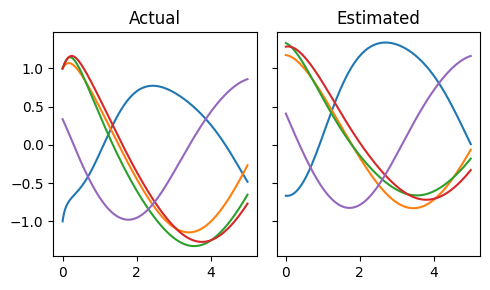

In [70]:
fig, ax = subplots(1,2, figsize=(5,3), sharey="all", sharex="all")
ax[1].set_title("Actual")
for i in 1:N
    ax[1].plot(Tos, Xos[:, i, 1])
end
ax[2].set_title("Estimated")
for i in 1:N
    ax[2].plot(Tgpm, Xgpm[:, i, 1])
end
tight_layout()